In [12]:
!pip install imblearn
!pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=012c2851efeb36df359e463bc740f91c3a21ccef7a349ba1d9b4eede4a6d0ad1
  Stored in directory: /Users/yijunshen/Library/Caches/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


In [14]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn import metrics, tree
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessio

ImportError: cannot import name '_ClassNamePrefixFeaturesOutMixin' from 'sklearn.base' (/Users/yijunshen/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py)

# Data loading & Preprocessing Funcs

In [2]:
# DATA LOADING
# Find file paths on kaggle
def find_all_file_paths():
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# Load data from CSV
def load_csv(data_dir, filename):
    df = pd.read_csv(os.path.join(data_dir, filename))
    return df


In [3]:
# CLEANING FUNCS
def drop_zero_variance_features(df):
    nunique = df.nunique() # num of unique values in each col
    drop_cols = nunique[nunique==1].keys().values
    for drop_col in drop_cols:
        df.drop([drop_col], axis=1, inplace=True)
        
    return df

def check_null_values(df):
    null_sum= df.isnull().sum()
    if null_sum.values.sum()!=0:
        print('WARNING!! THE FOLLOWING FEATURES CONTAIN NULL VALUES:')
        print(null_sum[null_num!=0].keys())
    else:
        print('No null values in existing dataframe.')
        
def check_dup_values(df):
    if df.duplicated().sum()==0:
        print('No duplicated rows in existing dataframe.')
    else:
        print('WARNING!! THE FOLLOWING ROWS CONTAIN DUPLICATES:')
        print(df[df.duplicated()])

        
        

    
    

In [4]:
# PREPROCESSING

def label_encoder(df, feature_list):
    '''
    Feature list: list of features that you want to encode from categorical data
    '''
    le = LabelEncoder()
    for i in feature_list:
        df[i] = le.fit_transform(df[i])
    return df

def one_hot_encoder(df,feature_list):

    ohe = OneHotEncoder(
        categories='auto',  # Categories per feature
        drop=None, # Whether to drop one of the features
        sparse=True, # Will return sparse matrix if set True
        dtype=np.float64, # Desired data type of the output
        handle_unknown='error' # Whether to raise an error 
    )   
    for i in feature_list:
        transformed = ohe.fit_transform(df[[i]])
        df[ohe.categories_[0]] = transformed.toarray()
        df.drop([i],axis=1,inplace=True)
    return df

def split_feature_target(df,target): 
    X = df.drop(target,axis =1)
    y = df[target]
    return X,y

def normalize_features(X):
    sc = StandardScaler()
    X = sc.fit_transform(X)
#     assert(np.mean(X, axis=0)[np.random.randint(X.shape[1])]==0)
#     assert(np.std(X, axis=0)[np.random.randint(X.shape[1])]==1)
   
    return X
    

In [5]:
def balanced_sampler(X,y, random_state=42):

    over = SMOTE(random_state=random_state)
    under = RandomUnderSampler()

    steps = [('o', over),('u', under)]
    imbpipeline = imbpipe(steps)

    X, y = imbpipeline.fit_resample(X, y)

    print(f'resampled y: {pd.Series(y).value_counts()}')
    return X,y

def initialize_model(model_name,params={}): 
    # Initialize model
    if model_name=='SVM':
        model=SVC(**params) 
    elif model_name=='DecisionTree':
        model=tree.DecisionTreeClassifier(**params)
    elif model_name=='LogisticRegression':
        model=LogisticRegression()
        model=RFE(model,**params)
#         else:
#             model=LogisticRegression()   # Default hyperparameters
#             model=RFE(model)
            
        
    return model

def test_metrics(model,X_test,y_test):
    y_pred=model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test,y_pred) # correctly predicted/all labels
    precision = metrics.precision_score(y_test, y_pred) # True positive / all detected positives (sensitivity)
    recall = metrics.recall_score(y_test, y_pred)  # True positive / all actual positives (true poitive + negative false)
    classification_report = metrics.classification_report(y_test, y_pred)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    return accuracy, precision, recall, classification_report, confusion_matrix, y_pred

def generate_hyperparams_dict(model_name):
    if model_name=='SVM':
        hyperparams_dict={
            'C': (np.arange(2,3,0.1)) , 
            'gamma': [0.01,0.02,0.03,0.04,0.05], 
            'kernel': ['linear', 'poly', 'rbf'],
            'degree': [2,3,4]
        }
    elif model_name =='DecisionTree':
        hyperparams_dict = {"criterion":("gini","entropy"),
               "splitter":("best","random"),
               "max_depth":list(range(1,20)),
               "min_samples_split":[2,3,4],
               "min_samples_leaf":list(range(1,20))}
    elif model_name == 'LogisticRegression':
        hyperparams_dict = [{'n_features_to_select':list(range(1,26))}]
    return hyperparams_dict
    


# Plotting funcs


In [6]:
def plot_correlation(df, method='spearman', show=True, cols=[], cmap='cool'):
    if show:
        if not cols:
            df=df
        else:
            df = df[cols]
        figure = plt.figure(figsize=(14,10))
        sns.heatmap(df.corr(method = method),
                    annot=True, 
                    fmt = ".1f", 
                    cmap = cmap)
        plt.show()

def plot_confusion_matrix(y_test, y_pred, classes=[0,1]):
    cnf_mat = metrics.confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted label')
    plt.ylabel('Real label')
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_mat), annot=True, cmap="RdBu_r" ,fmt='g')
    ax.xaxis.set_label_position("top")

# Main

## Data cleaning & preprocessing
save this result and use this result later

In [7]:
# Step 1: Data loading
df = load_csv(data_dir='/kaggle/input/ibm-hr-analytics-attrition-dataset/',filename='WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Step 2: Data Cleaning
# 2.0 Select useful columns
select_cols = ['Attrition','DistanceFromHome','Education','EnvironmentSatisfaction','Gender','JobLevel','JobRole','JobSatisfaction','MonthlyIncome','MonthlyRate','NumCompaniesWorked','PercentSalaryHike','TotalWorkingYears','WorkLifeBalance','YearsInCurrentRole']
df = df[select_cols]
# 2.1: Drop zero variance features
df = drop_zero_variance_features(df)
# 2.2 Check null values
check_null_values(df)
# 2.3 Check duplicates
check_dup_values(df)df

# Step 3: Data preprocessing
# 3.1 Categorical encoding: label encoding
df = label_encoder(df, feature_list=['Gender','Attrition'])
# One-hot encoding (Do we really need this for job role??)
df = one_hot_encoder(df,feature_list=['JobRole'])

# 3.2 Remove highly-correlated features
# Plot Correlation
plot_correlation(df, show=False, cmap='RdBu_r')
'''
'YearsInCurrentRole' strongly correlated to 'YearsAtCompany'
'JobLevel' strongly correlated to 'MonthlyIncome'
'JobLevel' strongly correlated to 'TotalWorkingYears'
'MonthlyIncome' strongly correlated to 'TotalWorkingYears'
'YearsAtCompany' strongly correlated to 'YearsWithCurrManager'
'YearsAtCompany' strongly correlated to 'YearsInCurrRole'
'YearsInCurrRole' strongly correlated to 'YearsWithCurrManager'
--> Remove 'TotalWorkingYears','YearsInCurrentRole','JobLevel', 'YearsWithCurrManager'
'''
remove_cols = ['TotalWorkingYears','YearsInCurrentRole','JobLevel']
df.drop(remove_cols, axis=1, inplace=True)
# 3.3 Normalize feature values
X,y = split_feature_target(df,target='Attrition')
X = normalize_features(X)
y= np.array(y)

# 3.4 Save CSV
df.to_csv('cleaned_data.csv')
df

SyntaxError: invalid syntax (2637241728.py, line 13)

In [8]:
model_name = 'SVM'
n_folds=5
resample_all=True

print(f'\n---Test model {model_name}---')

if resample_all:
    X_, y_ = balanced_sampler(X_train,y_train, random_state=42)
    # Train & test split
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.2, random_state = 42)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    # Resample train set to make it balance
    X_train, y_train = balanced_sampler(X_train,y_train, random_state=42)

# Train model once with default params--> test metrics
print("\n---Test model with default params---")
model = initialize_model(model_name=model_name)
model.fit(X_train,y_train)
accuracy, precision, recall, classification_report, confusion_matrix, y_pred = test_metrics(model=model,X_test=X_test,y_test=y_test)
print(f'Accuracy: {np.round(accuracy,3)}, Precision: {np.round(precision,3)}, Recall: {np.round(recall,3)}')
print(f'Classification report: \n {classification_report}')

# Hyperparameter search
print("\n---Search for best hyperparams---")
hyperparams_dict = generate_hyperparams_dict(model_name=model_name)
model_search = GridSearchCV(estimator=model, param_grid=hyperparams_dict, cv=n_folds, scoring='accuracy', verbose=1) # DO WE USE ACCURACY HERE OR RECALL??
model_search.fit(X_train, y_train)
print(f'Best model score {model_search.best_score_}')
best_params = model_search.best_params_
print(f'Best hyperparams: {best_params}')

# Test model with the best hyperparams
print("\n---Test model with best hyperparams---")
model_best = initialize_model(model_name=model_name, params=best_params)
model_best.fit(X_train,y_train)
accuracy, precision, recall, classification_report, confusion_matrix, y_pred = test_metrics(model=model_best,X_test=X_test,y_test=y_test)
print(f'Accuracy: {np.round(accuracy,3)}, Precision: {np.round(precision,3)}, Recall: {np.round(recall,3)}')
print(f'Classification report: \n {classification_report}')
plot_confusion_matrix(y_test, y_pred, classes=[0,1])


---Test model SVM---


NameError: name 'X_train' is not defined

### Additional funcs

In [9]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

y_pred=logreg.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

NameError: name 'logreg' is not defined

### Accuracy, Precision and Recall

In [28]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8707482993197279
Precision: 0.7391304347826086
Recall: 0.3469387755102041


### Area Under the Curve

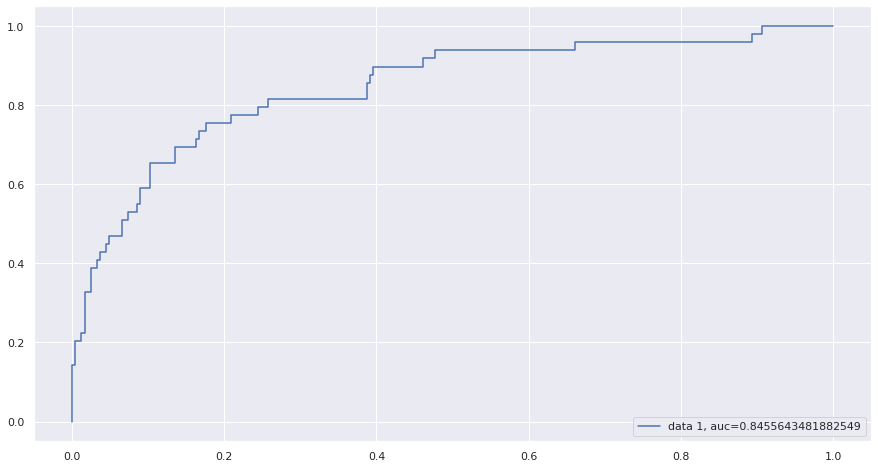

In [29]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
n_splits=5

params_dict={
    'C':2,
    'kernel':'rbf',
    'gamma':0.005
}
# Train and test model
model_name = 'SVM'
cv = KFold(n_splits=n_splits, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
scores=[]

for train_fold_index, val_fold_index in cv.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
    X_val_fold, y_val_fold = X_train[val_fold_index], y_train[val_fold_index]
    
    # Upsample only the data in the training section
    X_train_fold_upsample, y_train_fold_upsample = balanced_sampler(X_train_fold,y_train_fold, random_state=42)
    
    model = train_model(model_name=model_name, X_train=X_train_fold_upsample, y_train=y_train_fold_upsample, params=params_dict)
    # Score the model on the (non-upsampled) validation data
    score = metrics.recall_score(y_val_fold, model.predict(X_val_fold))
    scores.append(score)

print(np.array(scores))
# test_acc, test_precision, test_recall, y_pred= test_accuracy(model, X_test=X_test, y_test=y_test)
# print(f'Test accuracy for {model_name}: {test_acc}')
# print(f'Test precision for {model_name}: {test_precision}')
# print(f'Test recall for {model_name}: {test_recall}')

# # Confusion matrix plotting
# plot_confusion_matrix(y_test=y_test, y_pred=y_pred, classes=[0,1])
